In [1]:
import os
from PIL import Image
import numpy as np
import cv2
import tensorflow as tf
from concurrent.futures import ProcessPoolExecutor


2025-02-13 13:47:50.581751: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 13:47:50.743140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739472470.813813  187907 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739472470.833458  187907 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 13:47:50.998246: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Generate

# Yolo

In [3]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ProcessPoolExecutor

PATH_TO_TILES = os.path.expanduser('~/Documents/Code/Lung_Injury/Tiles/')
PATH_TO_COORDS = os.path.expanduser('~/Documents/Code/Lung_Injury/Coordinates/')
GENERATED_DIR = os.path.expanduser('~/Documents/Code/Lung_Injury/Generated_Masks')
RESIZED_TILES_DIR = os.path.expanduser('~/Documents/Code/Lung_Injury/Resized_Tiles')
YOLO_LABELS_DIR = os.path.expanduser('~/Documents/Code/Lung_Injury/YOLO_Labels')  

IMAGE_SIZE_W = 512
IMAGE_SIZE_L = 512

os.makedirs(GENERATED_DIR, exist_ok=True)
os.makedirs(RESIZED_TILES_DIR, exist_ok=True)
os.makedirs(YOLO_LABELS_DIR, exist_ok=True)  

def convert_to_yolo_format(x0, y0, x1, y1, img_width, img_height):
    """
    Convert (x0, y0, x1, y1) to YOLO format (x_center, y_center, width, height).
    Coordinates are normalized to [0, 1].
    """
    x_center = (x0 + x1) / 2 / img_width
    y_center = (y0 + y1) / 2 / img_height
    width = (x1 - x0) / img_width
    height = (y1 - y0) / img_height

    x_center = max(0, min(1, x_center))
    y_center = max(0, min(1, y_center))
    width = max(0, min(1, width))
    height = max(0, min(1, height))

    return x_center, y_center, width, height

def process_file(coord_file_path, tile_image_path, resized_subfolder_path, generated_subfolder_path, yolo_labels_subfolder_path):
    if os.path.getsize(coord_file_path) == 0:
        print(f"Skipping {coord_file_path} because it is empty.")
        return
    
    base_name = os.path.basename(coord_file_path)[:-11]
    with Image.open(tile_image_path) as img:
        orig_w, orig_h = img.size
        mask = np.zeros((orig_h, orig_w), dtype=np.uint8)
        yolo_labels = [] 
        
        with open(coord_file_path, "r") as file:
            lines = file.readlines()
            line_count = len(lines)
            for line in lines:
                coords = line.strip().split(",")
                if len(coords) >= 4:
                    x0, y0, x1, y1 = map(int, coords[:4])
                    x_center, y_center, width, height = convert_to_yolo_format(x0, y0, x1, y1, orig_w, orig_h)
                    yolo_labels.append(f"0 {x_center} {y_center} {width} {height}")
                    mask[y0:y1, x0:x1] = 255
        
        yolo_label_path = os.path.join(yolo_labels_subfolder_path, f"{base_name}_{line_count}.txt")
        with open(yolo_label_path, "w") as yolo_file:
            yolo_file.write("\n".join(yolo_labels))
        
        mask_resized = Image.fromarray(mask).resize((IMAGE_SIZE_W, IMAGE_SIZE_L), Image.NEAREST)
        img_resized = img.resize((IMAGE_SIZE_W, IMAGE_SIZE_L))
        
        resized_tile_path = os.path.join(resized_subfolder_path, f"{base_name}_{line_count}.png")
        img_resized.save(resized_tile_path)
        output_file_path = os.path.join(generated_subfolder_path, f"{base_name}_mask_{line_count}.png")
        mask_resized.save(output_file_path)

def process_subfolder(subfolder):
    coords_subfolder_path = os.path.join(PATH_TO_COORDS, subfolder)
    tiles_subfolder_path = os.path.join(PATH_TO_TILES, subfolder)
    generated_subfolder_path = os.path.join(GENERATED_DIR, subfolder)
    resized_subfolder_path = os.path.join(RESIZED_TILES_DIR, subfolder)
    yolo_labels_subfolder_path = os.path.join(YOLO_LABELS_DIR, subfolder)  
    
    if not os.path.exists(coords_subfolder_path):
        print(f"Skipping {subfolder} because no corresponding coordinates folder exists.")
        return
    
    if not os.path.exists(tiles_subfolder_path):
        print(f"Skipping {subfolder} because no corresponding tiles folder exists.")
        return
    
    os.makedirs(generated_subfolder_path, exist_ok=True)
    os.makedirs(resized_subfolder_path, exist_ok=True)
    os.makedirs(yolo_labels_subfolder_path, exist_ok=True) 
    
    with ProcessPoolExecutor() as executor:
        futures = []
        for coord_file in os.listdir(coords_subfolder_path):
            if coord_file.endswith("_coords.txt"):
                coord_file_path = os.path.join(coords_subfolder_path, coord_file)
                base_name = coord_file[:-11]
                tile_image_path = os.path.join(tiles_subfolder_path, base_name + ".png")
                if not os.path.exists(tile_image_path):
                    print(f"Skipping {tile_image_path} because the corresponding tile image does not exist.")
                    continue
                futures.append(executor.submit(process_file, coord_file_path, tile_image_path, resized_subfolder_path, generated_subfolder_path, yolo_labels_subfolder_path))
        for future in futures:
            future.result()

for observer_folder in os.listdir(PATH_TO_TILES):
    observer_path = os.path.join(PATH_TO_TILES, observer_folder)
    if os.path.isdir(observer_path):
        for subfolder in os.listdir(observer_path):
            subfolder_path = os.path.join(observer_path, subfolder)
            if os.path.isdir(subfolder_path):
                process_subfolder(os.path.join(observer_folder, subfolder))

Skipping /home/gandalf/Documents/Code/Lung_Injury/Coordinates/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_5/Aswcm5tile_24555_65152_coords.txt because it is empty.
Skipping /home/gandalf/Documents/Code/Lung_Injury/Coordinates/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_5/Aswcm5tile_58932_165934_coords.txt because it is empty.
Skipping /home/gandalf/Documents/Code/Lung_Injury/Coordinates/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_5/Aswcm5tile_26192_65152_coords.txt because it is empty.
Skipping /home/gandalf/Documents/Code/Lung_Injury/Coordinates/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_5/Aswcm5tile_27829_65152_coords.txt because it is empty.
Skipping /home/gandalf/Documents/Code/Lung_Injury/Coordinates/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_6/Aswcm6tile_40925_54972_coords.txt because it is empty.
Skipping /home/gandalf/Documents/Code/Lung_Injury/Coordinates/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_3/Aswcm3tile_45836_120124_coords.txt because it is emp

/home/gandalf/Documents/Code/Lung_Injury/YOLO/dataset/labels/train/tile_31103_51918_11.txt


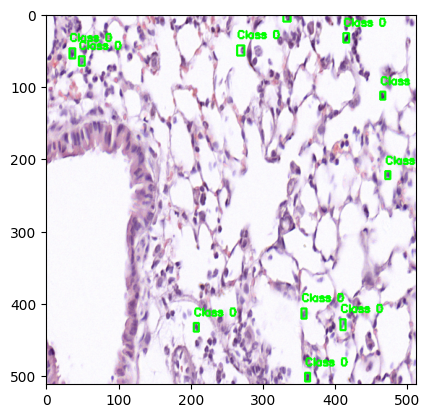

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt 


images_dir = os.path.expanduser("~/Documents/Code/Lung_Injury/YOLO/dataset/images/train")
labels_dir = os.path.expanduser("~/Documents/Code/Lung_Injury/YOLO/dataset/labels/train")

image_files = [f for f in os.listdir(images_dir) if f.endswith(".png") or f.endswith(".jpg")]
if not image_files:
    print("No images found in the directory.")
    exit()

random_image_file = random.choice(image_files)
random_image_path = os.path.join(images_dir, random_image_file)
random_label_path = os.path.join(labels_dir, random_image_file.replace(".png", ".txt").replace(".jpg", ".txt"))


print(random_label_path)
image = cv2.imread(random_image_path)
if image is None:
    print(f"Failed to load image: {random_image_path}")
    exit()

image_height, image_width, _ = image.shape

with open(random_label_path, "r") as f:
    annotations = f.readlines()

for annotation in annotations:
    parts = annotation.strip().split()
    if len(parts) == 5:
        class_id, x_center, y_center, width, height = map(float, parts)
        
        x_center *= image_width
        y_center *= image_height
        width *= image_width
        height *= image_height
        
        x0 = int(x_center - width / 2)
        y0 = int(y_center - height / 2)
        x1 = int(x_center + width / 2)
        y1 = int(y_center + height / 2)
        
        cv2.rectangle(image, (x0, y0), (x1, y1), (0, 255, 0), 2) 
        cv2.putText(image, f"Class {int(class_id)}", (x0, y0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# For Classifiaction (Low,High)

In [56]:
PATH_TO_TILES = "Tiles"
PATH_TO_COORDS = "Coordinates"
GENERATED_DIR = "Generated"
IMAGE_SIZE_W = 256
IMAGE_SIZE_L = 256

os.makedirs(GENERATED_DIR, exist_ok=True)

for subfolder in os.listdir(PATH_TO_COORDS):
    coords_subfolder_path = os.path.join(PATH_TO_COORDS, subfolder)
    tiles_subfolder_path = os.path.join(PATH_TO_TILES, subfolder)
    generated_subfolder_path = os.path.join(GENERATED_DIR, subfolder)

    if not os.path.exists(tiles_subfolder_path):
        continue

    os.makedirs(generated_subfolder_path, exist_ok=True)

    for coord_file in os.listdir(coords_subfolder_path):
        if coord_file.endswith("_coords.txt"):
            base_name = coord_file[:-11]

            coord_file_path = os.path.join(coords_subfolder_path, coord_file)
            tile_image_path = os.path.join(tiles_subfolder_path, base_name + ".png")

            if not os.path.exists(tile_image_path):
                continue

            with open(coord_file_path, 'r') as file:
                line_count = file.read().count('\n')

            label = "low" if line_count < 5 else "high"

            with Image.open(tile_image_path) as img:
                resized_img = img.resize((IMAGE_SIZE_W, IMAGE_SIZE_L))
                output_file_name = f"{base_name}_{label}.png"
                output_file_path = os.path.join(generated_subfolder_path, output_file_name)
                resized_img.save(output_file_path)

# Loading

#### Classif

In [64]:
image_data = np.empty((0, 256, 256, 3), dtype=np.float32) 
labels = np.empty((0,), dtype=np.int32)

def label_to_numeric(label):
    return 0 if label == "low" else 1  # Map "low" to 0 and "high" to 1

for subfolder in os.listdir(GENERATED_DIR):
    subfolder_path = os.path.join(GENERATED_DIR, subfolder)

    if os.path.isdir(subfolder_path): 
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)

            if file_name.endswith(".png"):
                label = file_name.split("_")[-1].split(".")[0]  # Get "low" or "high"

                with Image.open(file_path) as img:
                    if img.mode == "RGBA":
                        img = img.convert("RGB")

                    img_array = np.array(img) / 255.0  

                    if img_array.shape != (256, 256, 3):
                        print(f"Skipping image due to unexpected shape: {img_array.shape}")
                        continue

                    image_data = np.vstack([image_data, img_array[np.newaxis, ...]])
                    labels = np.append(labels, label_to_numeric(label))



#### Masked

In [3]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf


BATCH_SIZE = 16

def load_image(image_path):

    image = Image.open(image_path).convert("RGB")  
    image = np.array(image) / 255.0 
    return image

def load_mask(mask_path):

    mask = Image.open(mask_path).convert("L") 
    mask = np.array(mask) / 255.0 
    mask = np.expand_dims(mask, axis=-1) 
    return mask

def parse_filename(filename):

    base_name = os.path.basename(filename)
    count = int(base_name.split("_")[-1].split(".")[0]) 
    return count

def create_dataset(image_dir, mask_dir):

    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])

    print(f"Number of images: {len(image_paths)}")
    print(f"Number of masks: {len(mask_paths)}")

    if len(image_paths) != len(mask_paths):
        raise ValueError(f"Mismatch between number of images ({len(image_paths)}) and masks ({len(mask_paths)})")

    print("\nFirst 5 image paths:")
    for path in image_paths[:5]:
        print(path)
    print("\nFirst 5 mask paths:")
    for path in mask_paths[:5]:
        print(path)

    images = np.array([load_image(img_path) for img_path in image_paths])
    masks = np.array([load_mask(mask_path) for mask_path in mask_paths])
    counts = np.array([parse_filename(f) for f in image_paths], dtype=np.float32)

    print("\nShapes of loaded data:")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    print(f"Counts shape: {counts.shape}")

    dataset = tf.data.Dataset.from_tensor_slices((images, masks, counts))

    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# image_dir = "Resized_Tiles"
# mask_dir = "Generated_Masks"

mask_dir = os.path.expanduser('~/Documents/Code/Lung_Injury/Generated_Masks/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_3')
image_dir = os.path.expanduser('~/Documents/Code/Lung_Injury/Resized_Tiles/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_3')

print(f"Image directory exists: {os.path.exists(image_dir)}")
print(f"Mask directory exists: {os.path.exists(mask_dir)}")

dataset = create_dataset(image_dir, mask_dir)

for images, masks, counts in dataset.take(1):
    print("\nBatch shapes:")
    print("Images shape:", images.shape)
    print("Masks shape:", masks.shape)
    print("Counts:", counts.numpy())

Image directory exists: True
Mask directory exists: True
Number of images: 285
Number of masks: 285

First 5 image paths:
/home/gandalf/Documents/Code/Lung_Injury/Resized_Tiles/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_3/tile_18007_39702_1.png
/home/gandalf/Documents/Code/Lung_Injury/Resized_Tiles/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_3/tile_18007_40720_3.png
/home/gandalf/Documents/Code/Lung_Injury/Resized_Tiles/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_3/tile_18007_41738_3.png
/home/gandalf/Documents/Code/Lung_Injury/Resized_Tiles/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_3/tile_18007_42756_1.png
/home/gandalf/Documents/Code/Lung_Injury/Resized_Tiles/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_3/tile_19644_36648_3.png

First 5 mask paths:
/home/gandalf/Documents/Code/Lung_Injury/Generated_Masks/Observer-2 (Prarthna)/ALI_surgical_w_catheter_m_3/tile_18007_39702_mask_1.png
/home/gandalf/Documents/Code/Lung_Injury/Generated_Masks/Observer-2 (Prarthna)/ALI